# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np

import os
import time
import os
import copy
from shutil import move
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import butter, filtfilt

from talib import (
    CCI, RSI, STOCH, ROC, ULTOSC, AROONOSC, CMO, APO
)

Simply reading the dataset, that we have downloaded from the FXCM through their API.

In [2]:
OHLC_PATH = "data/fxcm_eur_usd_8h.csv"
df = pd.read_csv(OHLC_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16653 entries, 0 to 16652
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    16653 non-null  object 
 1   open    16653 non-null  float64
 2   close   16653 non-null  float64
 3   high    16653 non-null  float64
 4   low     16653 non-null  float64
 5   volume  16653 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 780.7+ KB


Parse date column and set it as index, so that the date is sorted by date and we do not have to deal with an additional column.

In [3]:
df["date"] = pd.to_datetime(df.date)
df.set_index("date", inplace=True)

We will also drop the volume column, since the particular techinical indicators we opted for do not use it

In [4]:
df.drop("volume", axis=1, inplace=True)
df

open     close      high       low
date                                                       
2001-09-09 21:00:00  0.902550  0.898100  0.908100  0.897400
2001-09-10 21:00:00  0.905650  0.913200  0.914900  0.895700
2001-09-11 21:00:00  0.910050  0.906900  0.915200  0.901700
2001-09-12 21:00:00  0.909000  0.911100  0.912700  0.905000
2001-09-13 21:00:00  0.916950  0.922800  0.924900  0.908400
...                       ...       ...       ...       ...
2022-04-05 13:00:00  1.093540  1.090445  1.097580  1.090005
2022-04-05 21:00:00  1.089980  1.089695  1.090840  1.089080
2022-04-06 05:00:00  1.091520  1.093335  1.093820  1.087435
2022-04-06 13:00:00  1.091665  1.089570  1.093735  1.087890
2022-04-06 21:00:00  1.089240  1.089495  1.090245  1.089195

[16653 rows x 4 columns]

## Indicators

Now, we will use the TA-Lib library to compute values of the indicators. 

In [5]:
df["ult"] = ULTOSC(df.high, df.low, df.close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
df['roc'] = ROC(df.close, timeperiod=10)
df["cci"] = CCI(df.high, df.low, df.close, timeperiod=24)

_, slowd = STOCH(df.high, df.low, df.close, fastk_period=10)
df["slow_d"] = slowd
df["rsi"] = RSI(df.close, timeperiod=24)
        
df["aroon"] = AROONOSC(df.high, df.low, 28)
df["chande"] = CMO(df.close, 28)
df["apo"] = APO(df.close, fastperiod=12, slowperiod=26, matype=0)
df

open     close      high       low        ult  \
date                                                                     
2001-09-09 21:00:00  0.902550  0.898100  0.908100  0.897400        NaN   
2001-09-10 21:00:00  0.905650  0.913200  0.914900  0.895700        NaN   
2001-09-11 21:00:00  0.910050  0.906900  0.915200  0.901700        NaN   
2001-09-12 21:00:00  0.909000  0.911100  0.912700  0.905000        NaN   
2001-09-13 21:00:00  0.916950  0.922800  0.924900  0.908400        NaN   
...                       ...       ...       ...       ...        ...   
2022-04-05 13:00:00  1.093540  1.090445  1.097580  1.090005  23.733582   
2022-04-05 21:00:00  1.089980  1.089695  1.090840  1.089080  22.104632   
2022-04-06 05:00:00  1.091520  1.093335  1.093820  1.087435  31.636865   
2022-04-06 13:00:00  1.091665  1.089570  1.093735  1.087890  34.360215   
2022-04-06 21:00:00  1.089240  1.089495  1.090245  1.089195  35.898078   

                          roc         cci     slow_d        rsi      aroon  \
date                                                                         
2001-09-09 21:00:00       NaN         NaN        NaN        NaN        NaN   
2001-09-10 21:00:00       NaN         NaN        NaN        NaN        NaN   
2001-09-11 21:00:00       NaN         NaN        NaN        NaN        NaN   
2001-09-12 21:00:00       NaN         NaN        NaN        NaN        NaN   
2001-09-13 21:00:00       NaN         NaN        NaN        NaN        NaN   
...                       ...         ...        ...        ...        ...   
2022-04-05 13:00:00 -1.466555 -130.398783   3.266363  38.882361 -42.857143   
2022-04-05 21:00:00 -1.510297 -147.229256   3.453366  38.370866 -46.428571   
2022-04-06 05:00:00 -1.002798 -119.596251   6.440169  42.220216 -50.000000   
2022-04-06 13:00:00 -1.380315 -123.486236  10.770077  39.553751 -50.000000   
2022-04-06 21:00:00 -1.309389 -122.254792  15.828085  39.501893 -50.000000   

                        chande       apo  
date                                      
2001-09-09 21:00:00        NaN       NaN  
2001-09-10 21:00:00        NaN       NaN  
2001-09-11 21:00:00        NaN       NaN  
2001-09-12 21:00:00        NaN       NaN  
2001-09-13 21:00:00        NaN       NaN  
...                        ...       ...  
2022-04-05 13:00:00 -19.585044 -0.001486  
2022-04-05 21:00:00 -20.482498 -0.002677  
2022-04-06 05:00:00 -14.074836 -0.003519  
2022-04-06 13:00:00 -18.712076 -0.004584  
2022-04-06 21:00:00 -18.802601 -0.005480  

[16653 rows x 12 columns]

All technical indicators produce some NaNs at the beginning, since indicators are computed from the previous values of the asset, which are not present at the beginnig. To fix this, we will just drop rows with NaNs in them.

In [6]:
df.dropna(inplace=True)
df

open     close      high       low        ult  \
date                                                                     
2001-10-17 21:00:00  0.903700  0.903400  0.905900  0.899800  49.152421   
2001-10-18 21:00:00  0.900900  0.898400  0.903800  0.896900  46.610151   
2001-10-18 21:00:00  0.903705  0.903405  0.905905  0.899805  51.031478   
2001-10-19 21:00:00  0.900905  0.898405  0.903805  0.896905  43.365051   
2001-10-21 21:00:00  0.898905  0.899205  0.899205  0.898005  44.084313   
...                       ...       ...       ...       ...        ...   
2022-04-05 13:00:00  1.093540  1.090445  1.097580  1.090005  23.733582   
2022-04-05 21:00:00  1.089980  1.089695  1.090840  1.089080  22.104632   
2022-04-06 05:00:00  1.091520  1.093335  1.093820  1.087435  31.636865   
2022-04-06 13:00:00  1.091665  1.089570  1.093735  1.087890  34.360215   
2022-04-06 21:00:00  1.089240  1.089495  1.090245  1.089195  35.898078   

                          roc         cci     slow_d        rsi      aroon  \
date                                                                         
2001-10-17 21:00:00 -1.579693 -157.268686  31.496416  51.636158  14.285714   
2001-10-18 21:00:00 -2.284098 -170.648888  22.205483  49.379775  14.285714   
2001-10-18 21:00:00 -1.814477 -119.702573  17.239311  51.589391 -85.714286   
2001-10-19 21:00:00 -1.641668 -140.324680  13.964365  49.344077 -85.714286   
2001-10-21 21:00:00 -1.327225 -134.828881  14.658959  49.709508 -85.714286   
...                       ...         ...        ...        ...        ...   
2022-04-05 13:00:00 -1.466555 -130.398783   3.266363  38.882361 -42.857143   
2022-04-05 21:00:00 -1.510297 -147.229256   3.453366  38.370866 -46.428571   
2022-04-06 05:00:00 -1.002798 -119.596251   6.440169  42.220216 -50.000000   
2022-04-06 13:00:00 -1.380315 -123.486236  10.770077  39.553751 -50.000000   
2022-04-06 21:00:00 -1.309389 -122.254792  15.828085  39.501893 -50.000000   

                        chande       apo  
date                                      
2001-10-17 21:00:00   3.940520 -0.004828  
2001-10-18 21:00:00   0.082195 -0.005706  
2001-10-18 21:00:00   3.789553 -0.006168  
2001-10-19 21:00:00  -0.052418 -0.006899  
2001-10-21 21:00:00   0.558359 -0.007556  
...                        ...       ...  
2022-04-05 13:00:00 -19.585044 -0.001486  
2022-04-05 21:00:00 -20.482498 -0.002677  
2022-04-06 05:00:00 -14.074836 -0.003519  
2022-04-06 13:00:00 -18.712076 -0.004584  
2022-04-06 21:00:00 -18.802601 -0.005480  

[16625 rows x 12 columns]

## Filtering

To smoothen the indicators' values, we are going to apply Butterworth filter to them. This will help models generalize and it will make our extrapolations a bit more sane.

After some experimentation, we laned on parameter values 4 and .15. A visualisation of the filter in action can be seen below.

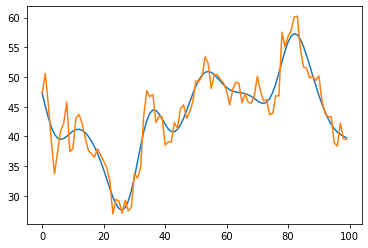

In [7]:
b, a = butter(4, .15, btype='low', analog=False)
filtered = filtfilt(b, a, df.rsi[-100:])
plt.plot(filtered)
plt.plot(np.arange(100), df.rsi[-100:])

In [8]:
df["ult"] = filtfilt(b, a, df["ult"])
df['roc'] = filtfilt(b, a, df["roc"])
df["cci"] = filtfilt(b, a, df["cci"])
df["slow_d"] = filtfilt(b, a, df["slow_d"])
df["rsi"] = filtfilt(b, a, df["rsi"])
df["aroon"] = filtfilt(b, a, df["aroon"])
df["chande"] = filtfilt(b, a, df["chande"])
df["apo"] = filtfilt(b, a, df["apo"])

## Labels

Now we will split the data set into windows and label them. The output of the labels function is going to be an array of labels and and array of all windows' start and end To store labels in a proper numpy array we will encode them as integers, and then we will decode them back during the image generation phase.

Labels are generated depending on which order would be triggereed within the `threshold_length` ticks. It can either be take profit (LONG) or cut losses (SHORT), or neither (HOLD).

In [9]:
def labels(df, threshold=10, window_length=20, threshold_length=10, overlap = 0):
    buffer =  window_length * 2 - overlap 
    window_indices = [(i, i + window_length) for i in range(0, len(df.index) - buffer, window_length - overlap)][:-1]
    labels = np.zeros(len(window_indices) - 1)
    for i, (start, end) in enumerate(window_indices[:-1]):
        current_window = df.close[start:end]
        future = df.close[end:end+threshold_length]
        label = 0
        diff = (future - current_window.iloc[-1]) * 10000 # For EUR/USD
        trigger = diff.iloc[np.argmax(abs(diff) > threshold)]
        if abs(trigger) > threshold:
            label = 1 if trigger > 0 else 2
        labels[i] = label
    return labels, window_indices

In [10]:
lbls, window_indicies = labels(df, threshold=80, threshold_length=10, overlap=17)

## Fourier extrapolation

We are going to extrapolate values of every window and generate an image from that extrapolation. Extrapolation will be done with the help of FFT. We will decompose the signal into cosine components, extrapolate them separately, and sum them together to recostruct the signal.

In [11]:
def fourier_extrapolation(signal: np.ndarray, add: int = 12) -> np.ndarray:
    n = len(signal)
    signal_in_freq_domain = np.fft.fft(signal)
    sample_frequencies = np.fft.fftfreq(n)
    amplitudes = np.absolute(signal_in_freq_domain) / n
    phases = np.angle(signal_in_freq_domain)
    x = np.arange(0, n + add)
    return np.sum(
        amplitudes * np.cos(2 * np.pi * sample_frequencies * x[:, np.newaxis] + phases),
        axis=1
    )

A demonstartion on a simple periodic function is provided below. It obviously will not work as well on the Forex data, but it should still be useful.

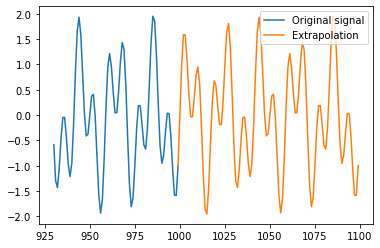

In [12]:
dt = 0.001
t = np.arange(0, 1, dt)
f = np.sin(2 * np.pi * 50 * t) + np.sin(2 * np.pi * 120 * t)
predicted_f = fourier_extrapolation(f, 240)
plt.plot(np.arange(0, len(f))[930:1000], f[930:1000])
plt.plot(np.arange(0, len(predicted_f))[999:1100], predicted_f[999:1100])
plt.legend(['Original signal', 'Extrapolation'])

## Generating images

We are going to generate two types of images: with thresholds and without. Let's start with the simple ones. For them we are going to plot the graph and fill the area under it with green or red color, depending if the currenet value is positive or negative. An example can be seen below.

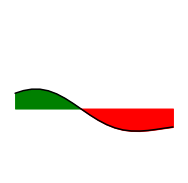

In [123]:
def simple_image(extrapolation, y_lim=None, color=False, save_path=None):
    x = np.arange(0, len(extrapolation))
    y = extrapolation
    fig, ax = plt.subplots()
    dpi = fig.get_dpi()
    
    if y_lim:
        ax.set_ylim(*y_lim)
    
    fig.set_size_inches((224 / dpi, 224 / dpi))
    if color:
        ax.fill_between(x, y, where=y >= 0, interpolate=True, color='green')
        ax.fill_between(x, y, where=y <= 0, interpolate=True, color='red')
    
    ax.plot(x, y, c="black")
    ax.axis("off")
    if save_path:
        fig.savefig(save_path, dpi=dpi)
    else:
        plt.show()
    
    plt.close(fig)

simple_image(
        df.roc[-20:],
        color=True,
        y_lim=(np.min(df["roc"]), np.max(df["roc"])),
    )


For images of the more complex indicators, we will add upper and lower thesholds. In the images we will only color the are betwern the graph and the thresholds, to highlight their importance, otherwise the area under the graph is filled with black. An exmaple can be seen below.

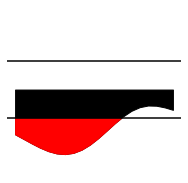

In [124]:
def oscillator_image(extrapolation, lower_bound, upper_bound, zero=None, y_lim=None, save_path=None):
    x = np.arange(0, len(extrapolation))
    y = extrapolation
    
    fig, ax = plt.subplots()
    dpi = fig.get_dpi()
    fig.set_size_inches((224 / dpi, 224 / dpi))
    
    if y_lim is not None:
        ax.set_ylim(*y_lim)
    
    ax.axhline(y=upper_bound, color='black', linestyle='-')
    ax.axhline(y=lower_bound, color='black', linestyle='-')
    
    if zero is not None:
        ax.fill_between(x, y, zero, where=y >= zero, interpolate=True, color='black')
        ax.fill_between(x, y, zero, where=y <= zero, interpolate=True, color='black')
    else:
        ax.plot(x, y, c="black")
    
    ax.fill_between(x, y, upper_bound, where=y >= upper_bound, interpolate=True, color='green')
    ax.fill_between(x, y, lower_bound, where=y <= lower_bound, interpolate=True, color='red')
    
    ax.axis("off")
    
    if save_path:
        fig.savefig(save_path, dpi=dpi)
    else:
        plt.show()
    
    plt.close(fig)

oscillator_image(
    df.rsi[-80:-60],
    lower_bound=40,
    upper_bound=60,
    y_lim=(np.min(df["rsi"]), np.max(df["rsi"])),
    zero=50,
)


To train or models on the images, we are going to take advantage of PyTorch's `datasets.ImageFolder` to create a data set from a directory with images. To do so, we have to store our images in a specific folder structure. This said structure is created by the following function.

In [125]:
def create_dirs(generate_path, dataset_name):
    Path(f"{generate_path}/{dataset_name}/train/HOLD").mkdir(parents=True, exist_ok=True)
    Path(f"{generate_path}/{dataset_name}/train/LONG").mkdir(parents=True, exist_ok=True)
    Path(f"{generate_path}/{dataset_name}/train/SHORT").mkdir(parents=True, exist_ok=True)
    Path(f"{generate_path}/{dataset_name}/test/HOLD").mkdir(parents=True, exist_ok=True)
    Path(f"{generate_path}/{dataset_name}/test/LONG").mkdir(parents=True, exist_ok=True)
    Path(f"{generate_path}/{dataset_name}/test/SHORT").mkdir(parents=True, exist_ok=True)
    Path(f"{generate_path}/{dataset_name}/val/HOLD").mkdir(parents=True, exist_ok=True)
    Path(f"{generate_path}/{dataset_name}/val/LONG").mkdir(parents=True, exist_ok=True)
    Path(f"{generate_path}/{dataset_name}/val/SHORT").mkdir(parents=True, exist_ok=True)

In [126]:
indicators = [  # These have to match column names from the dataset
    "ult",
    'roc',
    "cci",
    "slow_d",
    "rsi",
    "aroon",
    "chande",
    "apo"
]

In [127]:
# Pick a folder, where you want all datasets to be genreated
PATH_TO_IMAGES = "generated"

for indicator in indicators:
    create_dirs(PATH_TO_IMAGES, indicator)

When splitting time series data into training, validation and test sets, we want to make sure that we are predicting the future using the past values and not the other way around. We will split images into sets during the generation using the following function.

And we will also have to decode the label to it's string name.

In [128]:
def get_stage(total, i, val_threhold = .8, test_threhsold = .9):
    stage = "train"
    if i > total * val_threhold:
        stage = "val"
    if i > total * test_threhsold:
        stage = "test"
    return stage

def get_label(label):
    label_str = "HOLD"
    if label == 1:
        label_str = "LONG"
    if label == 2:
        label_str = "SHORT"
    return label_str

There is no beautiful way to pass all the specific parameters to image genreation functions, so we will have to do with a huge for loop.

In [129]:
EXTRAPOLATION_LENGTH = 20

In [130]:
i = 0
total = len(window_indicies) - 1
for (start, end), label in zip(window_indicies[:-1], lbls):
    stage = get_stage(total, i)
    window = df[start:end]
    label_str = get_label(label)
        
    simple_image(
        fourier_extrapolation(window["roc"], add=EXTRAPOLATION_LENGTH)[-EXTRAPOLATION_LENGTH:],
        color=True,
        y_lim=(np.min(df["roc"]), np.max(df["roc"])),
        save_path=f"{PATH_TO_IMAGES}/roc/{stage}/{label_str}/{i}.png"
    )
    oscillator_image(
        fourier_extrapolation(window["cci"], add=EXTRAPOLATION_LENGTH)[-EXTRAPOLATION_LENGTH:],
        lower_bound=-100,
        upper_bound=100,
        y_lim=(np.min(df["cci"]), np.max(df["cci"])),
        zero=0,
        save_path=f"{PATH_TO_IMAGES}/cci/{stage}/{label_str}/{i}.png"
    )
    
    oscillator_image(
        fourier_extrapolation(window["slow_d"], add=EXTRAPOLATION_LENGTH)[-EXTRAPOLATION_LENGTH:],
        lower_bound=30,
        upper_bound=70,
        y_lim=(np.min(df["slow_d"]), np.max(df["slow_d"])),
        zero=50,
        save_path=f"{PATH_TO_IMAGES}/slow_d/{stage}/{label_str}/{i}.png"
    )
    oscillator_image(
        fourier_extrapolation(window["ult"], add=EXTRAPOLATION_LENGTH)[-EXTRAPOLATION_LENGTH:],
        lower_bound=40,
        upper_bound=60,
        y_lim=(np.min(df["ult"]), np.max(df["ult"])),
        zero=50,
        save_path=f"{PATH_TO_IMAGES}/ult/{stage}/{label_str}/{i}.png"
    )

    
    oscillator_image(
        fourier_extrapolation(window["aroon"], add=EXTRAPOLATION_LENGTH)[-EXTRAPOLATION_LENGTH:],
        lower_bound=50,
        upper_bound=50,
        y_lim=(np.min(df["aroon"]), np.max(df["aroon"])),
        zero=50,
        save_path=f"{PATH_TO_IMAGES}/aroon/{stage}/{label_str}/{i}.png"
    )
    
    oscillator_image(
        fourier_extrapolation(window["chande"], add=EXTRAPOLATION_LENGTH)[-EXTRAPOLATION_LENGTH:],
        lower_bound=-20,
        upper_bound=20,
        y_lim=(np.min(df["chande"]), np.max(df["chande"])),
        zero=0,
        save_path=f"{PATH_TO_IMAGES}/chande/{stage}/{label_str}/{i}.png"
    )
    
    oscillator_image(
        fourier_extrapolation(window["apo"], add=EXTRAPOLATION_LENGTH)[-EXTRAPOLATION_LENGTH:],
        lower_bound=0,
        upper_bound=0,
        y_lim=(np.min(df["apo"]), np.max(df["apo"])),
        zero=0,
        save_path=f"{PATH_TO_IMAGES}/apo/{stage}/{label_str}/{i}.png"
    )
    
    oscillator_image(
        fourier_extrapolation(window["rsi"], add=EXTRAPOLATION_LENGTH)[-EXTRAPOLATION_LENGTH:],
        lower_bound=40,
        upper_bound=60,
        y_lim=(np.min(df["rsi"]), np.max(df["rsi"])),
        zero=50,
        save_path=f"{PATH_TO_IMAGES}/rsi/{stage}/{label_str}/{i}.png"
    )
    
    i += 1


After genreating the images, we can proceed to the model training. (Modeling code is in a separate file)

The results, that we have achieved, can be seen below.

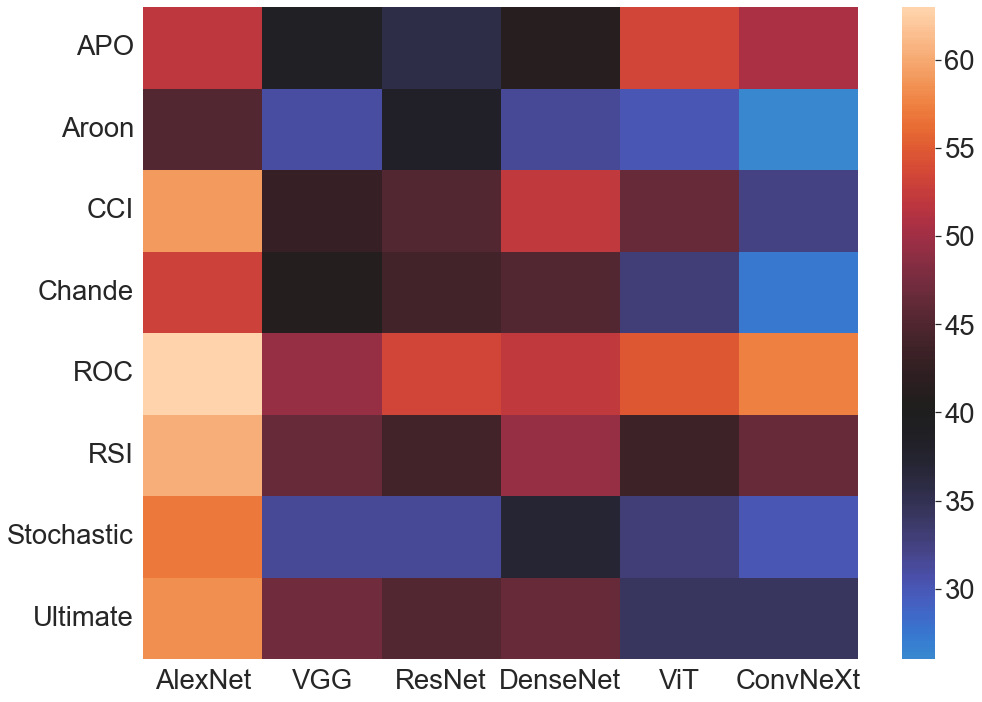

In [132]:
results = [
  [52.0, 38.6, 35.6, 41.1, 53.4, 50.7],
  [45.1, 31.0, 38.4, 31.5, 30.1, 26.0],
  [59.0, 43.0, 45.2, 52.1, 46.6, 32.4],
  [53.0, 41.0, 43.8, 45.2, 32.9, 27.4],
  [63.0, 49.3, 53.4, 52.1, 54.8, 57.5],
  [60.3, 46.6, 43.8, 49.3, 43.6, 46.6],
  [57.0, 31.5, 31.5, 37.0, 32.9, 30.1],
  [58.4, 47.0, 45.2, 46.6, 34.2, 34.2]
]

sns.set(font_scale = 2.5)
plt.rcParams["figure.figsize"] = [16, 12]

sns.heatmap(
    results,
    center=40.0,
    xticklabels=["AlexNet", "VGG", "ResNet", "DenseNet", "ViT", "ConvNeXt"],
    yticklabels=["APO", "Aroon", "CCI", "Chande", "ROC", "RSI", "Stochastic", "Ultimate"]
)
plt.rcParams["figure.figsize"] = [6.4, 4.8]
sns.set(font_scale = 1)

# plt.savefig('acc_heat.png')